# **HOMEWORK 2 batch version**

In [11]:
#%history -f output.txt

# **Libraries importation**

In [12]:
import os
import cv2
import scipy
import numpy as np 
import tensorflow as tf
from PIL import Image
from collections import defaultdict
from matplotlib import pyplot as plt 
from sklearn.utils.class_weight import compute_class_weight
from tensorflow import keras
from keras.regularizers import l2
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Dense, Flatten, Dropout, BatchNormalization
from tensorflow.keras.metrics import Precision, Recall, BinaryAccuracy
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.preprocessing.image import ImageDataGenerator

print('libraries imported')

libraries imported


# **settings**

In [13]:
# Avoid OOM errors by setting GPU memory consumption growth
gpus = tf.config.experimental.list_physical_devices('GPU')
for gpu in gpus:
    tf.config.experimental.set_memory_growth(gpu, True)

# **Data Collection**

## **Data Augmentation**

In [14]:
datagen = ImageDataGenerator(
    rotation_range=0,
    width_shift_range=0,
    height_shift_range=0,
    shear_range=0,
    zoom_range=0,
    horizontal_flip=True,
    rescale=1./255
)

## **Data Load**

In [15]:
Train = datagen.flow_from_directory(
    'train',
    target_size=(256,256),
    batch_size=32,
    class_mode='categorical'
)

train_labels = []
train_labels = Train.classes
num_classes = Train.num_classes
train_labels_one_hot = tf.keras.utils.to_categorical(train_labels, num_classes=num_classes)


Found 6369 images belonging to 5 classes.


## **Visualization of the dataset**

In [16]:
def visualize_dataset(dataset, num_samples=5):
    for images, labels in dataset:
        num_samples_batch = min(num_samples, len(images))
        fig, ax = plt.subplots(1, num_samples_batch, figsize=(20, 20))
        
        for i in range(num_samples_batch):
            ax[i].imshow((images[i] * 255).astype("uint8"))  # Remove the rescaling here
            ax[i].set_title(f"Label: {labels[i]}")
            ax[i].axis("off")
        
        plt.show()
        break


# num_samples = 5
# for images, labels in Train.take(1):
#     num_samples_batch = min(num_samples, len(images))
#     fig, ax = plt.subplots(1, num_samples_batch, figsize=(20, 20))
#     for i in range(num_samples):
#         ax[i].imshow(images[i].numpy().astype("uint8"))
#         ax[i].set_title(f"Label: {labels[i]}")
#         ax[i].axis("off")
#     plt.show()

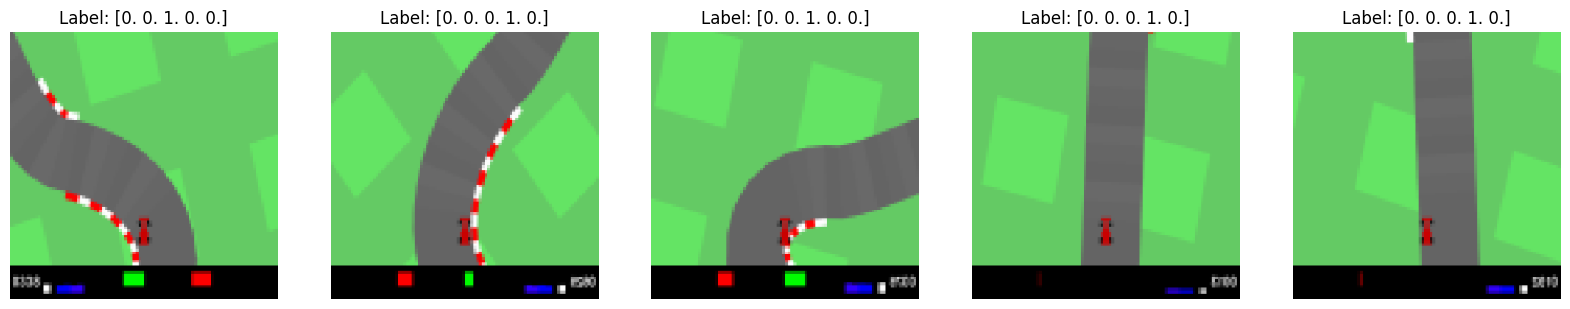

In [17]:
visualize_dataset(Train)

# **Data Preprocessing**
-    Resize images to a common size (e.g., 96x96, as mentioned in the description).
-    Normalize pixel values to a range between 0 and 1.
-    Consider data augmentation techniques (e.g., rotation, flipping) to increase the diversity of your training set.    

# **Model Selection:**
## Model Design
-    Define your own CNN architecture. Start with a simple architecture and gradually increase complexity if needed.
-    Experiment with different layer configurations, activation functions, and filter sizes.
-    Consider incorporating dropout for regularization.

## **Approach 1**
-   Define the first approach with a specific architecture, optimizer, and regularization techniques.
-   Choose appropriate hyperparameters (learning rate, batch size, etc.).
-   Train the model on the training set and evaluate on the test set.
-   Collect and analyze metrics such as accuracy, precision, recall, and F1 score.

In [18]:
model = Sequential()

In [19]:
# Layers
# (3,3) is the pixel selection, 1 is the translation of pixels
model.add(Conv2D(32, (3,3), activation='relu', input_shape=(256,256,3)))
model.add(MaxPooling2D())
model.add(Dropout(0.25))

model.add(Conv2D(64, (3,3), activation='relu'))
model.add(MaxPooling2D())
model.add(Dropout(0.25))

model.add(Conv2D(128, (3,3), activation='relu'))
model.add(MaxPooling2D())
model.add(Dropout(0.25))

model.add(Flatten())

model.add(Dense(512, activation='relu'))
model.add(Dropout(0.5)) # Dropout layer to reduce overfitting

num_classes = 5
model.add(Dense(num_classes, activation='softmax'))

In [20]:
optimizer = Adam(learning_rate=0.001)

In [21]:
model.compile(optimizer, loss=tf._losses.CategoricalCrossentropy(), metrics=['accuracy'])

In [22]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 254, 254, 32)      896       
                                                                 
 max_pooling2d (MaxPooling2  (None, 127, 127, 32)      0         
 D)                                                              
                                                                 
 dropout (Dropout)           (None, 127, 127, 32)      0         
                                                                 
 conv2d_1 (Conv2D)           (None, 125, 125, 64)      18496     
                                                                 
 max_pooling2d_1 (MaxPoolin  (None, 62, 62, 64)        0         
 g2D)                                                            
                                                                 
 dropout_1 (Dropout)         (None, 62, 62, 64)        0

## **Approach 2**
-    Define the second approach with a different architecture, optimizer, or regularization techniques.
-    Adjust hyperparameters independently of the first approach.
-    Train the model on the training set and evaluate on the test set.
-    Collect and analyze metrics as done for the first approach.

In [51]:
model = keras.models.Sequential([
    keras.layers.Flatten(input_shape=(256, 256, 3)),
    keras.layers.Dense(64, activation='relu', kernel_regularizer=keras.regularizers.l2(0.001)),
    keras.layers.Dense(32, activation='relu', kernel_regularizer=keras.regularizers.l2(0.001)),
    keras.layers.Dense(num_classes, activation='softmax')
])

In [52]:
beta_1 = 0.9
beta_2 = 0.999
optimizer = Adam(learning_rate=0.01, beta_1=beta_1, beta_2=beta_2)

In [53]:
model.compile(optimizer, loss=tf._losses.CategoricalCrossentropy(), metrics=['accuracy'])

In [54]:
model.summary

<bound method Model.summary of <keras.src.engine.sequential.Sequential object at 0x7fee0b64a6e0>>

## **Hyperparameter Analysis**
-   Choose at least one hyperparameter (e.g., learning rate) and perform a systematic analysis.
-   Train models with different values of the chosen hyperparameter.
-   Compare and visualize the impact on metrics.
-   Consider to apply an early stopping of the training in order to avoid overfitting (see slide 11 pag 55)
-   Consider if to apply Dropout or parameter sharing


# **Model Training**

In [55]:
logdir = 'logs'
tensorboard_callback = tf.keras.callbacks.TensorBoard(log_dir=logdir)

**without validation data:**

In [56]:
class_labels = np.unique(train_labels)
class_weights = compute_class_weight(class_weight='balanced', classes=np.unique(train_labels), y=train_labels)
class_weights_dict = dict(zip(class_labels, class_weights))

In [57]:
hist = model.fit(Train, epochs=20, callbacks=[tensorboard_callback], class_weight=class_weights_dict)

Epoch 1/20
200/200 [==============================] - 24s 119ms/step - loss: 60.9023 - accuracy: 0.1726
Epoch 2/20
200/200 [==============================] - 23s 115ms/step - loss: 4.2770 - accuracy: 0.2068
Epoch 3/20
200/200 [==============================] - 23s 113ms/step - loss: 2.3106 - accuracy: 0.1572
Epoch 4/20
200/200 [==============================] - 23s 114ms/step - loss: 1.7657 - accuracy: 0.1696
Epoch 5/20
200/200 [==============================] - 23s 114ms/step - loss: 1.6542 - accuracy: 0.1715
Epoch 6/20
200/200 [==============================] - 23s 114ms/step - loss: 1.6322 - accuracy: 0.2407
Epoch 7/20
200/200 [==============================] - 23s 115ms/step - loss: 2.6176 - accuracy: 0.2266
Epoch 8/20
200/200 [==============================] - 23s 114ms/step - loss: 1.7754 - accuracy: 0.1449
Epoch 9/20
200/200 [==============================] - 23s 115ms/step - loss: 2.0546 - accuracy: 0.1945
Epoch 10/20
200/200 [==============================] - 23s 114ms/step - 

## **Plotting Model Performance**

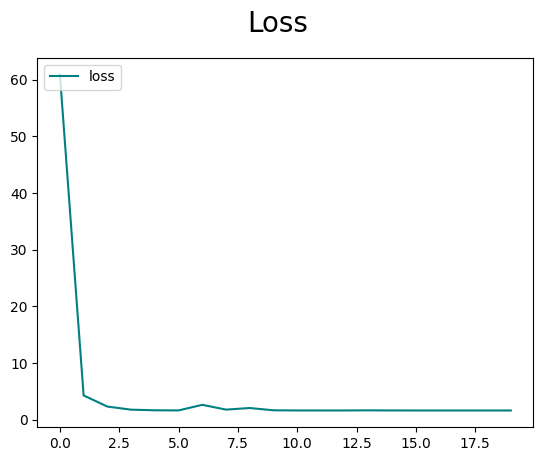

In [58]:
fig = plt.figure()
plt.plot(hist.history['loss'], color='teal', label='loss')
fig.suptitle('Loss', fontsize=20)
plt.legend(loc="upper left")
plt.show()

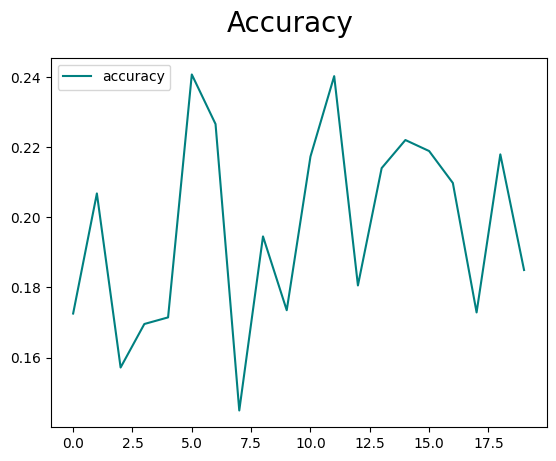

In [59]:
fig = plt.figure()
plt.plot(hist.history['accuracy'], color='teal', label='accuracy')
fig.suptitle('Accuracy', fontsize=20)
plt.legend(loc="upper left")
plt.show()

# **Evaluate Performance**

In [60]:
pre = Precision()
re = Recall()
acc = BinaryAccuracy()

# **Test**

In [61]:
Test = tf.keras.utils.image_dataset_from_directory('test')
test_iterator = Test.as_numpy_iterator()

all_X_test = []
all_y_test = []

for test_batch in test_iterator:
    X_test_batch, y_test_batch = test_batch
    X_test_normalized_batch = X_test_batch/255.0
    yhat_batch = model.predict(X_test_normalized_batch)
    all_X_test.append(X_test_normalized_batch)
    all_y_test.append(y_test_batch)

X_test_normalized = np.concatenate(all_X_test)
y_test = np.concatenate(all_y_test)

test_iterator = Test.as_numpy_iterator()
Test_batch = next(test_iterator)
X_test, y_test = Test_batch
X_test_normalized = X_test/255.0

Found 2749 files belonging to 5 classes.
1/1 [==============================] - 0s 40ms/step


In [62]:
yhat = model.predict(X_test_normalized)

1/1 [==============================] - 0s 28ms/step


In [63]:
pre = Precision()
re = Recall()
acc = BinaryAccuracy()

In [64]:
for batch in Test.as_numpy_iterator():
    X, y = batch
    yhat = model.predict(X)
    y_one_hot = tf.keras.utils.to_categorical(y, num_classes=num_classes)
    pre.update_state(y_one_hot, yhat)
    re.update_state(y_one_hot, yhat)
    acc.update_state(y_one_hot, yhat)                                    

1/1 [==============================] - 0s 18ms/step


In [67]:
print(f'Precision:{pre.result().numpy()}, Recall:{re.result().numpy()}, Accuracy:{acc.result().numpy()}')

Precision:0.0, Recall:0.0, Accuracy:0.800000011920929


# **Results Visualization and Comparison**
-    Create visualizations (tables, charts, graphs) to present your results.
-    Provide detailed commentary on each visualization, explaining trends or differences observed.

## **Comparison on accuracy between methods**

### **On train**

In [ ]:
fig=plt.figure(figsize=(16, 8))
# insert comparison on accuracies

plt.suptitle('Model accuracy comparison on train', fontsize=14)
plt.show()

### **On Test**

In [ ]:
fig=plt.figure(figsize=(16, 8))
# insert comparison on accuracies

plt.suptitle('Model accuracy comparison on test', fontsize=14)
plt.show()

## **Fine-Tuning**

## **Deployment**

##valutazioni da fare poi:
- regularization per ridurre l'overfitting?
- il numero di images cambia da classe  a classe (train) vedere se serve prenderne un numero uguale per ciascuna classe
- 